# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 956us/sample - loss: 247.8642 - y1_output_loss: 119.0293 - y2_output_loss: 126.4836 - y1_output_root_mean_squared_error: 10.9624 - y2_output_root_mean_squared_error: 11.3000 - val_loss: 30.9559 - val_y1_output_loss: 14.4137 - val_y2_output_loss: 16.1464 - val_y1_output_root_mean_squared_error: 3.8473 - val_y2_output_root_mean_squared_error: 4.0192
Epoch 2/500
614/614 [==============================] - 0s 165us/sample - loss: 35.6920 - y1_output_loss: 12.8021 - y2_output_loss: 22.7544 - y1_output_root_mean_squared_error: 3.5794 - y2_output_root_mean_squared_error: 4.7833 - val_loss: 58.7086 - val_y1_output_loss: 16.8347 - val_y2_output_loss: 42.5740 - val_y1_output_root_mean_squared_error: 4.1185 - val_y2_output_root_mean_squared_error: 6.4612
Epoch 3/500
614/614 [==============================] - 0s 142us/sample - loss: 26.0574 - y1_output_loss: 10.2459 - y2_output_loss: 15.7994 - y1

614/614 [==============================] - 0s 164us/sample - loss: 17.1159 - y1_output_loss: 6.8918 - y2_output_loss: 10.0875 - y1_output_root_mean_squared_error: 2.6364 - y2_output_root_mean_squared_error: 3.1884 - val_loss: 11.6552 - val_y1_output_loss: 5.1768 - val_y2_output_loss: 6.3273 - val_y1_output_root_mean_squared_error: 2.3030 - val_y2_output_root_mean_squared_error: 2.5202
Epoch 22/500
614/614 [==============================] - 0s 141us/sample - loss: 16.5221 - y1_output_loss: 6.4014 - y2_output_loss: 10.2648 - y1_output_root_mean_squared_error: 2.5260 - y2_output_root_mean_squared_error: 3.1846 - val_loss: 19.7762 - val_y1_output_loss: 5.5416 - val_y2_output_loss: 13.8556 - val_y1_output_root_mean_squared_error: 2.3950 - val_y2_output_root_mean_squared_error: 3.7470
Epoch 23/500
614/614 [==============================] - 0s 135us/sample - loss: 17.5462 - y1_output_loss: 6.5835 - y2_output_loss: 10.8480 - y1_output_root_mean_squared_error: 2.5702 - y2_output_root_mean_squar

614/614 [==============================] - 0s 141us/sample - loss: 11.9299 - y1_output_loss: 3.8152 - y2_output_loss: 8.0089 - y1_output_root_mean_squared_error: 1.9617 - y2_output_root_mean_squared_error: 2.8428 - val_loss: 8.7343 - val_y1_output_loss: 3.2444 - val_y2_output_loss: 5.6949 - val_y1_output_root_mean_squared_error: 1.8048 - val_y2_output_root_mean_squared_error: 2.3403
Epoch 42/500
614/614 [==============================] - 0s 145us/sample - loss: 7.7505 - y1_output_loss: 2.5679 - y2_output_loss: 5.2105 - y1_output_root_mean_squared_error: 1.6064 - y2_output_root_mean_squared_error: 2.2737 - val_loss: 7.5940 - val_y1_output_loss: 2.2506 - val_y2_output_loss: 5.2813 - val_y1_output_root_mean_squared_error: 1.5215 - val_y2_output_root_mean_squared_error: 2.2976
Epoch 43/500
614/614 [==============================] - 0s 137us/sample - loss: 8.7561 - y1_output_loss: 2.7667 - y2_output_loss: 5.9243 - y1_output_root_mean_squared_error: 1.6670 - y2_output_root_mean_squared_error

Epoch 62/500
614/614 [==============================] - 0s 139us/sample - loss: 7.0706 - y1_output_loss: 2.0988 - y2_output_loss: 4.9277 - y1_output_root_mean_squared_error: 1.4526 - y2_output_root_mean_squared_error: 2.2272 - val_loss: 4.5333 - val_y1_output_loss: 1.5484 - val_y2_output_loss: 3.1215 - val_y1_output_root_mean_squared_error: 1.2507 - val_y2_output_root_mean_squared_error: 1.7231
Epoch 63/500
614/614 [==============================] - 0s 139us/sample - loss: 4.9408 - y1_output_loss: 1.4368 - y2_output_loss: 3.5071 - y1_output_root_mean_squared_error: 1.1973 - y2_output_root_mean_squared_error: 1.8727 - val_loss: 7.4900 - val_y1_output_loss: 2.9267 - val_y2_output_loss: 4.8624 - val_y1_output_root_mean_squared_error: 1.6936 - val_y2_output_root_mean_squared_error: 2.1498
Epoch 64/500
614/614 [==============================] - 0s 128us/sample - loss: 7.3670 - y1_output_loss: 2.1481 - y2_output_loss: 5.1581 - y1_output_root_mean_squared_error: 1.4699 - y2_output_root_mean_s

Epoch 83/500
614/614 [==============================] - 0s 131us/sample - loss: 3.7209 - y1_output_loss: 0.8782 - y2_output_loss: 2.8149 - y1_output_root_mean_squared_error: 0.9403 - y2_output_root_mean_squared_error: 1.6842 - val_loss: 3.0843 - val_y1_output_loss: 0.6666 - val_y2_output_loss: 2.4738 - val_y1_output_root_mean_squared_error: 0.8084 - val_y2_output_root_mean_squared_error: 1.5591
Epoch 84/500
614/614 [==============================] - 0s 131us/sample - loss: 5.5060 - y1_output_loss: 1.4531 - y2_output_loss: 4.0445 - y1_output_root_mean_squared_error: 1.1946 - y2_output_root_mean_squared_error: 2.0196 - val_loss: 5.1640 - val_y1_output_loss: 1.2815 - val_y2_output_loss: 3.9453 - val_y1_output_root_mean_squared_error: 1.1426 - val_y2_output_root_mean_squared_error: 1.9643
Epoch 85/500
614/614 [==============================] - 0s 141us/sample - loss: 4.4489 - y1_output_loss: 1.0968 - y2_output_loss: 3.4004 - y1_output_root_mean_squared_error: 1.0433 - y2_output_root_mean_s

Epoch 104/500
614/614 [==============================] - 0s 147us/sample - loss: 4.1590 - y1_output_loss: 1.0886 - y2_output_loss: 3.0499 - y1_output_root_mean_squared_error: 1.0475 - y2_output_root_mean_squared_error: 1.7498 - val_loss: 2.5366 - val_y1_output_loss: 0.6773 - val_y2_output_loss: 1.9128 - val_y1_output_root_mean_squared_error: 0.8298 - val_y2_output_root_mean_squared_error: 1.3594
Epoch 105/500
614/614 [==============================] - 0s 166us/sample - loss: 2.4611 - y1_output_loss: 0.5600 - y2_output_loss: 1.9255 - y1_output_root_mean_squared_error: 0.7486 - y2_output_root_mean_squared_error: 1.3787 - val_loss: 2.5524 - val_y1_output_loss: 0.6364 - val_y2_output_loss: 2.0408 - val_y1_output_root_mean_squared_error: 0.7854 - val_y2_output_root_mean_squared_error: 1.3912
Epoch 106/500
614/614 [==============================] - 0s 132us/sample - loss: 2.7798 - y1_output_loss: 0.5432 - y2_output_loss: 2.2399 - y1_output_root_mean_squared_error: 0.7337 - y2_output_root_mea

614/614 [==============================] - 0s 162us/sample - loss: 2.0406 - y1_output_loss: 0.4662 - y2_output_loss: 1.5615 - y1_output_root_mean_squared_error: 0.6854 - y2_output_root_mean_squared_error: 1.2533 - val_loss: 1.5991 - val_y1_output_loss: 0.3822 - val_y2_output_loss: 1.2566 - val_y1_output_root_mean_squared_error: 0.6098 - val_y2_output_root_mean_squared_error: 1.1078
Epoch 125/500
614/614 [==============================] - 0s 131us/sample - loss: 2.4796 - y1_output_loss: 0.5169 - y2_output_loss: 1.9453 - y1_output_root_mean_squared_error: 0.7219 - y2_output_root_mean_squared_error: 1.3995 - val_loss: 2.4014 - val_y1_output_loss: 0.4312 - val_y2_output_loss: 1.9790 - val_y1_output_root_mean_squared_error: 0.6512 - val_y2_output_root_mean_squared_error: 1.4062
Epoch 126/500
614/614 [==============================] - 0s 130us/sample - loss: 2.0184 - y1_output_loss: 0.4364 - y2_output_loss: 1.5733 - y1_output_root_mean_squared_error: 0.6636 - y2_output_root_mean_squared_erro

Epoch 145/500
614/614 [==============================] - 0s 132us/sample - loss: 2.1532 - y1_output_loss: 0.4543 - y2_output_loss: 1.6954 - y1_output_root_mean_squared_error: 0.6736 - y2_output_root_mean_squared_error: 1.3036 - val_loss: 2.4182 - val_y1_output_loss: 0.5009 - val_y2_output_loss: 1.9940 - val_y1_output_root_mean_squared_error: 0.6940 - val_y2_output_root_mean_squared_error: 1.3916
Epoch 146/500
614/614 [==============================] - 0s 135us/sample - loss: 2.3525 - y1_output_loss: 0.4842 - y2_output_loss: 1.8971 - y1_output_root_mean_squared_error: 0.6910 - y2_output_root_mean_squared_error: 1.3693 - val_loss: 6.8649 - val_y1_output_loss: 2.5333 - val_y2_output_loss: 4.1512 - val_y1_output_root_mean_squared_error: 1.6135 - val_y2_output_root_mean_squared_error: 2.0643
Epoch 147/500
614/614 [==============================] - 0s 131us/sample - loss: 1.7684 - y1_output_loss: 0.4289 - y2_output_loss: 1.3444 - y1_output_root_mean_squared_error: 0.6559 - y2_output_root_mea

614/614 [==============================] - 0s 142us/sample - loss: 1.6979 - y1_output_loss: 0.3442 - y2_output_loss: 1.3427 - y1_output_root_mean_squared_error: 0.5883 - y2_output_root_mean_squared_error: 1.1627 - val_loss: 1.2254 - val_y1_output_loss: 0.2859 - val_y2_output_loss: 0.9354 - val_y1_output_root_mean_squared_error: 0.5371 - val_y2_output_root_mean_squared_error: 0.9680
Epoch 166/500
614/614 [==============================] - 0s 142us/sample - loss: 1.4498 - y1_output_loss: 0.2570 - y2_output_loss: 1.2027 - y1_output_root_mean_squared_error: 0.5003 - y2_output_root_mean_squared_error: 1.0952 - val_loss: 10.8047 - val_y1_output_loss: 2.6504 - val_y2_output_loss: 8.0428 - val_y1_output_root_mean_squared_error: 1.6343 - val_y2_output_root_mean_squared_error: 2.8520
Epoch 167/500
614/614 [==============================] - 0s 135us/sample - loss: 2.1333 - y1_output_loss: 0.4374 - y2_output_loss: 1.7141 - y1_output_root_mean_squared_error: 0.6644 - y2_output_root_mean_squared_err

Epoch 186/500
614/614 [==============================] - 0s 138us/sample - loss: 1.0035 - y1_output_loss: 0.2102 - y2_output_loss: 0.8003 - y1_output_root_mean_squared_error: 0.4564 - y2_output_root_mean_squared_error: 0.8918 - val_loss: 1.3768 - val_y1_output_loss: 0.3655 - val_y2_output_loss: 0.9867 - val_y1_output_root_mean_squared_error: 0.6077 - val_y2_output_root_mean_squared_error: 1.0037
Epoch 187/500
614/614 [==============================] - 0s 136us/sample - loss: 1.1524 - y1_output_loss: 0.2320 - y2_output_loss: 0.9269 - y1_output_root_mean_squared_error: 0.4795 - y2_output_root_mean_squared_error: 0.9605 - val_loss: 2.4524 - val_y1_output_loss: 0.4367 - val_y2_output_loss: 2.0078 - val_y1_output_root_mean_squared_error: 0.6703 - val_y2_output_root_mean_squared_error: 1.4153
Epoch 188/500
614/614 [==============================] - 0s 138us/sample - loss: 1.8717 - y1_output_loss: 0.3857 - y2_output_loss: 1.4699 - y1_output_root_mean_squared_error: 0.6237 - y2_output_root_mea

614/614 [==============================] - 0s 135us/sample - loss: 1.0170 - y1_output_loss: 0.2228 - y2_output_loss: 0.7900 - y1_output_root_mean_squared_error: 0.4727 - y2_output_root_mean_squared_error: 0.8908 - val_loss: 1.1143 - val_y1_output_loss: 0.2632 - val_y2_output_loss: 0.8381 - val_y1_output_root_mean_squared_error: 0.5149 - val_y2_output_root_mean_squared_error: 0.9215
Epoch 207/500
614/614 [==============================] - 0s 139us/sample - loss: 0.8291 - y1_output_loss: 0.1943 - y2_output_loss: 0.6460 - y1_output_root_mean_squared_error: 0.4375 - y2_output_root_mean_squared_error: 0.7986 - val_loss: 2.3820 - val_y1_output_loss: 0.6812 - val_y2_output_loss: 1.7134 - val_y1_output_root_mean_squared_error: 0.8262 - val_y2_output_root_mean_squared_error: 1.3036
Epoch 208/500
614/614 [==============================] - 0s 152us/sample - loss: 0.9535 - y1_output_loss: 0.2029 - y2_output_loss: 0.7454 - y1_output_root_mean_squared_error: 0.4511 - y2_output_root_mean_squared_erro

Epoch 227/500
614/614 [==============================] - 0s 159us/sample - loss: 1.7360 - y1_output_loss: 0.4221 - y2_output_loss: 1.3723 - y1_output_root_mean_squared_error: 0.6406 - y2_output_root_mean_squared_error: 1.1514 - val_loss: 12.3955 - val_y1_output_loss: 5.5553 - val_y2_output_loss: 6.4451 - val_y1_output_root_mean_squared_error: 2.3982 - val_y2_output_root_mean_squared_error: 2.5776
Epoch 228/500
614/614 [==============================] - 0s 134us/sample - loss: 1.1618 - y1_output_loss: 0.2959 - y2_output_loss: 0.8577 - y1_output_root_mean_squared_error: 0.5443 - y2_output_root_mean_squared_error: 0.9303 - val_loss: 1.2408 - val_y1_output_loss: 0.3173 - val_y2_output_loss: 0.9056 - val_y1_output_root_mean_squared_error: 0.5677 - val_y2_output_root_mean_squared_error: 0.9584
Epoch 229/500
614/614 [==============================] - 0s 135us/sample - loss: 1.6180 - y1_output_loss: 0.3737 - y2_output_loss: 1.2384 - y1_output_root_mean_squared_error: 0.6123 - y2_output_root_me

614/614 [==============================] - 0s 131us/sample - loss: 0.7113 - y1_output_loss: 0.1637 - y2_output_loss: 0.5520 - y1_output_root_mean_squared_error: 0.3974 - y2_output_root_mean_squared_error: 0.7439 - val_loss: 2.2024 - val_y1_output_loss: 0.3510 - val_y2_output_loss: 1.8245 - val_y1_output_root_mean_squared_error: 0.5927 - val_y2_output_root_mean_squared_error: 1.3606
Epoch 248/500
614/614 [==============================] - 0s 132us/sample - loss: 0.7877 - y1_output_loss: 0.1714 - y2_output_loss: 0.6140 - y1_output_root_mean_squared_error: 0.4150 - y2_output_root_mean_squared_error: 0.7845 - val_loss: 1.3671 - val_y1_output_loss: 0.3923 - val_y2_output_loss: 0.9766 - val_y1_output_root_mean_squared_error: 0.6251 - val_y2_output_root_mean_squared_error: 0.9881
Epoch 249/500
614/614 [==============================] - 0s 138us/sample - loss: 0.8587 - y1_output_loss: 0.1788 - y2_output_loss: 0.6759 - y1_output_root_mean_squared_error: 0.4235 - y2_output_root_mean_squared_erro

Epoch 268/500
614/614 [==============================] - 0s 142us/sample - loss: 0.9605 - y1_output_loss: 0.2111 - y2_output_loss: 0.7489 - y1_output_root_mean_squared_error: 0.4595 - y2_output_root_mean_squared_error: 0.8656 - val_loss: 3.3152 - val_y1_output_loss: 0.9372 - val_y2_output_loss: 2.2970 - val_y1_output_root_mean_squared_error: 0.9815 - val_y2_output_root_mean_squared_error: 1.5335
Epoch 269/500
614/614 [==============================] - 0s 138us/sample - loss: 0.8886 - y1_output_loss: 0.2003 - y2_output_loss: 0.6874 - y1_output_root_mean_squared_error: 0.4479 - y2_output_root_mean_squared_error: 0.8295 - val_loss: 2.6881 - val_y1_output_loss: 0.7276 - val_y2_output_loss: 1.9151 - val_y1_output_root_mean_squared_error: 0.8581 - val_y2_output_root_mean_squared_error: 1.3970
Epoch 270/500
614/614 [==============================] - 0s 130us/sample - loss: 0.7093 - y1_output_loss: 0.1698 - y2_output_loss: 0.5352 - y1_output_root_mean_squared_error: 0.4124 - y2_output_root_mea

614/614 [==============================] - 0s 134us/sample - loss: 0.8451 - y1_output_loss: 0.1722 - y2_output_loss: 0.6757 - y1_output_root_mean_squared_error: 0.4152 - y2_output_root_mean_squared_error: 0.8202 - val_loss: 1.6798 - val_y1_output_loss: 0.2709 - val_y2_output_loss: 1.3856 - val_y1_output_root_mean_squared_error: 0.5240 - val_y2_output_root_mean_squared_error: 1.1854
Epoch 289/500
614/614 [==============================] - 0s 130us/sample - loss: 0.7731 - y1_output_loss: 0.1724 - y2_output_loss: 0.5941 - y1_output_root_mean_squared_error: 0.4166 - y2_output_root_mean_squared_error: 0.7743 - val_loss: 0.8634 - val_y1_output_loss: 0.2238 - val_y2_output_loss: 0.6236 - val_y1_output_root_mean_squared_error: 0.4733 - val_y2_output_root_mean_squared_error: 0.7996
Epoch 290/500
614/614 [==============================] - 0s 139us/sample - loss: 0.7647 - y1_output_loss: 0.1523 - y2_output_loss: 0.6194 - y1_output_root_mean_squared_error: 0.3889 - y2_output_root_mean_squared_erro

Epoch 309/500
614/614 [==============================] - 0s 133us/sample - loss: 0.6652 - y1_output_loss: 0.1487 - y2_output_loss: 0.5181 - y1_output_root_mean_squared_error: 0.3847 - y2_output_root_mean_squared_error: 0.7192 - val_loss: 1.4580 - val_y1_output_loss: 0.4382 - val_y2_output_loss: 1.0187 - val_y1_output_root_mean_squared_error: 0.6604 - val_y2_output_root_mean_squared_error: 1.0109
Epoch 310/500
614/614 [==============================] - 0s 156us/sample - loss: 0.9102 - y1_output_loss: 0.2065 - y2_output_loss: 0.7054 - y1_output_root_mean_squared_error: 0.4547 - y2_output_root_mean_squared_error: 0.8387 - val_loss: 2.6126 - val_y1_output_loss: 0.6976 - val_y2_output_loss: 1.9161 - val_y1_output_root_mean_squared_error: 0.8362 - val_y2_output_root_mean_squared_error: 1.3832
Epoch 311/500
614/614 [==============================] - 0s 137us/sample - loss: 1.0628 - y1_output_loss: 0.2531 - y2_output_loss: 0.8008 - y1_output_root_mean_squared_error: 0.5052 - y2_output_root_mea

614/614 [==============================] - 0s 151us/sample - loss: 0.6212 - y1_output_loss: 0.1473 - y2_output_loss: 0.4715 - y1_output_root_mean_squared_error: 0.3856 - y2_output_root_mean_squared_error: 0.6874 - val_loss: 1.3416 - val_y1_output_loss: 0.3361 - val_y2_output_loss: 0.9732 - val_y1_output_root_mean_squared_error: 0.5833 - val_y2_output_root_mean_squared_error: 1.0007
Epoch 330/500
614/614 [==============================] - 0s 136us/sample - loss: 0.6872 - y1_output_loss: 0.1572 - y2_output_loss: 0.5313 - y1_output_root_mean_squared_error: 0.3914 - y2_output_root_mean_squared_error: 0.7307 - val_loss: 1.2230 - val_y1_output_loss: 0.2472 - val_y2_output_loss: 0.9603 - val_y1_output_root_mean_squared_error: 0.4980 - val_y2_output_root_mean_squared_error: 0.9874
Epoch 331/500
614/614 [==============================] - 0s 140us/sample - loss: 0.7292 - y1_output_loss: 0.1718 - y2_output_loss: 0.5527 - y1_output_root_mean_squared_error: 0.4159 - y2_output_root_mean_squared_erro

Epoch 350/500
614/614 [==============================] - 0s 142us/sample - loss: 0.5544 - y1_output_loss: 0.1191 - y2_output_loss: 0.4339 - y1_output_root_mean_squared_error: 0.3444 - y2_output_root_mean_squared_error: 0.6601 - val_loss: 1.6775 - val_y1_output_loss: 0.4006 - val_y2_output_loss: 1.2616 - val_y1_output_root_mean_squared_error: 0.6363 - val_y2_output_root_mean_squared_error: 1.1281
Epoch 351/500
614/614 [==============================] - 0s 139us/sample - loss: 0.6806 - y1_output_loss: 0.1732 - y2_output_loss: 0.5816 - y1_output_root_mean_squared_error: 0.4176 - y2_output_root_mean_squared_error: 0.7115 - val_loss: 21.2544 - val_y1_output_loss: 1.8003 - val_y2_output_loss: 19.4226 - val_y1_output_root_mean_squared_error: 1.3506 - val_y2_output_root_mean_squared_error: 4.4080
Epoch 352/500
614/614 [==============================] - 0s 136us/sample - loss: 1.0227 - y1_output_loss: 0.1538 - y2_output_loss: 0.8603 - y1_output_root_mean_squared_error: 0.3937 - y2_output_root_m

614/614 [==============================] - 0s 142us/sample - loss: 0.5133 - y1_output_loss: 0.1390 - y2_output_loss: 0.3721 - y1_output_root_mean_squared_error: 0.3736 - y2_output_root_mean_squared_error: 0.6114 - val_loss: 1.2760 - val_y1_output_loss: 0.3163 - val_y2_output_loss: 0.9316 - val_y1_output_root_mean_squared_error: 0.5691 - val_y2_output_root_mean_squared_error: 0.9758
Epoch 371/500
614/614 [==============================] - 0s 135us/sample - loss: 0.6663 - y1_output_loss: 0.1791 - y2_output_loss: 0.4880 - y1_output_root_mean_squared_error: 0.4245 - y2_output_root_mean_squared_error: 0.6972 - val_loss: 1.0773 - val_y1_output_loss: 0.4452 - val_y2_output_loss: 0.6167 - val_y1_output_root_mean_squared_error: 0.6775 - val_y2_output_root_mean_squared_error: 0.7863
Epoch 372/500
614/614 [==============================] - 0s 136us/sample - loss: 0.5266 - y1_output_loss: 0.1320 - y2_output_loss: 0.3899 - y1_output_root_mean_squared_error: 0.3649 - y2_output_root_mean_squared_erro

Epoch 391/500
614/614 [==============================] - 0s 138us/sample - loss: 0.5047 - y1_output_loss: 0.1549 - y2_output_loss: 0.3480 - y1_output_root_mean_squared_error: 0.3953 - y2_output_root_mean_squared_error: 0.5903 - val_loss: 0.7706 - val_y1_output_loss: 0.2496 - val_y2_output_loss: 0.5097 - val_y1_output_root_mean_squared_error: 0.4996 - val_y2_output_root_mean_squared_error: 0.7218
Epoch 392/500
614/614 [==============================] - 0s 141us/sample - loss: 0.4079 - y1_output_loss: 0.1146 - y2_output_loss: 0.2920 - y1_output_root_mean_squared_error: 0.3397 - y2_output_root_mean_squared_error: 0.5409 - val_loss: 0.7641 - val_y1_output_loss: 0.2092 - val_y2_output_loss: 0.5354 - val_y1_output_root_mean_squared_error: 0.4590 - val_y2_output_root_mean_squared_error: 0.7439
Epoch 393/500
614/614 [==============================] - 0s 154us/sample - loss: 0.5554 - y1_output_loss: 0.1237 - y2_output_loss: 0.4283 - y1_output_root_mean_squared_error: 0.3528 - y2_output_root_mea

614/614 [==============================] - 0s 144us/sample - loss: 0.3866 - y1_output_loss: 0.0990 - y2_output_loss: 0.2849 - y1_output_root_mean_squared_error: 0.3149 - y2_output_root_mean_squared_error: 0.5361 - val_loss: 0.9096 - val_y1_output_loss: 0.3192 - val_y2_output_loss: 0.5674 - val_y1_output_root_mean_squared_error: 0.5736 - val_y2_output_root_mean_squared_error: 0.7620
Epoch 412/500
614/614 [==============================] - 0s 151us/sample - loss: 0.5307 - y1_output_loss: 0.1425 - y2_output_loss: 0.3897 - y1_output_root_mean_squared_error: 0.3789 - y2_output_root_mean_squared_error: 0.6222 - val_loss: 1.6020 - val_y1_output_loss: 0.3509 - val_y2_output_loss: 1.2272 - val_y1_output_root_mean_squared_error: 0.5969 - val_y2_output_root_mean_squared_error: 1.1161
Epoch 413/500
614/614 [==============================] - 0s 135us/sample - loss: 0.4269 - y1_output_loss: 0.1159 - y2_output_loss: 0.3083 - y1_output_root_mean_squared_error: 0.3411 - y2_output_root_mean_squared_erro

Epoch 432/500
614/614 [==============================] - 0s 134us/sample - loss: 0.3983 - y1_output_loss: 0.1202 - y2_output_loss: 0.2790 - y1_output_root_mean_squared_error: 0.3472 - y2_output_root_mean_squared_error: 0.5270 - val_loss: 1.3879 - val_y1_output_loss: 0.2417 - val_y2_output_loss: 1.1625 - val_y1_output_root_mean_squared_error: 0.4935 - val_y2_output_root_mean_squared_error: 1.0697
Epoch 433/500
614/614 [==============================] - 0s 134us/sample - loss: 0.4283 - y1_output_loss: 0.1220 - y2_output_loss: 0.3031 - y1_output_root_mean_squared_error: 0.3507 - y2_output_root_mean_squared_error: 0.5526 - val_loss: 0.7147 - val_y1_output_loss: 0.2407 - val_y2_output_loss: 0.4635 - val_y1_output_root_mean_squared_error: 0.4923 - val_y2_output_root_mean_squared_error: 0.6873
Epoch 434/500
614/614 [==============================] - 0s 132us/sample - loss: 0.4217 - y1_output_loss: 0.1207 - y2_output_loss: 0.3158 - y1_output_root_mean_squared_error: 0.3418 - y2_output_root_mea

614/614 [==============================] - 0s 139us/sample - loss: 0.3860 - y1_output_loss: 0.1066 - y2_output_loss: 0.2766 - y1_output_root_mean_squared_error: 0.3278 - y2_output_root_mean_squared_error: 0.5278 - val_loss: 0.8687 - val_y1_output_loss: 0.2866 - val_y2_output_loss: 0.5608 - val_y1_output_root_mean_squared_error: 0.5436 - val_y2_output_root_mean_squared_error: 0.7571
Epoch 453/500
614/614 [==============================] - 0s 136us/sample - loss: 0.3430 - y1_output_loss: 0.1064 - y2_output_loss: 0.2352 - y1_output_root_mean_squared_error: 0.3261 - y2_output_root_mean_squared_error: 0.4864 - val_loss: 0.9784 - val_y1_output_loss: 0.3067 - val_y2_output_loss: 0.6582 - val_y1_output_root_mean_squared_error: 0.5538 - val_y2_output_root_mean_squared_error: 0.8196
Epoch 454/500
614/614 [==============================] - 0s 141us/sample - loss: 0.3572 - y1_output_loss: 0.1017 - y2_output_loss: 0.2565 - y1_output_root_mean_squared_error: 0.3168 - y2_output_root_mean_squared_erro

Epoch 473/500
614/614 [==============================] - 0s 131us/sample - loss: 0.4525 - y1_output_loss: 0.1142 - y2_output_loss: 0.3413 - y1_output_root_mean_squared_error: 0.3391 - y2_output_root_mean_squared_error: 0.5810 - val_loss: 0.6770 - val_y1_output_loss: 0.1990 - val_y2_output_loss: 0.4764 - val_y1_output_root_mean_squared_error: 0.4494 - val_y2_output_root_mean_squared_error: 0.6893
Epoch 474/500
614/614 [==============================] - 0s 138us/sample - loss: 0.5597 - y1_output_loss: 0.1132 - y2_output_loss: 0.4424 - y1_output_root_mean_squared_error: 0.3376 - y2_output_root_mean_squared_error: 0.6676 - val_loss: 0.6868 - val_y1_output_loss: 0.2250 - val_y2_output_loss: 0.4462 - val_y1_output_root_mean_squared_error: 0.4780 - val_y2_output_root_mean_squared_error: 0.6770
Epoch 475/500
614/614 [==============================] - 0s 138us/sample - loss: 0.4731 - y1_output_loss: 0.1286 - y2_output_loss: 0.3428 - y1_output_root_mean_squared_error: 0.3569 - y2_output_root_mea

614/614 [==============================] - 0s 133us/sample - loss: 0.2935 - y1_output_loss: 0.0960 - y2_output_loss: 0.1974 - y1_output_root_mean_squared_error: 0.3099 - y2_output_root_mean_squared_error: 0.4443 - val_loss: 0.8044 - val_y1_output_loss: 0.2204 - val_y2_output_loss: 0.5667 - val_y1_output_root_mean_squared_error: 0.4717 - val_y2_output_root_mean_squared_error: 0.7628
Epoch 494/500
614/614 [==============================] - 0s 135us/sample - loss: 0.3535 - y1_output_loss: 0.1086 - y2_output_loss: 0.2486 - y1_output_root_mean_squared_error: 0.3281 - y2_output_root_mean_squared_error: 0.4958 - val_loss: 1.0545 - val_y1_output_loss: 0.3088 - val_y2_output_loss: 0.7658 - val_y1_output_root_mean_squared_error: 0.5553 - val_y2_output_root_mean_squared_error: 0.8638
Epoch 495/500
614/614 [==============================] - 0s 148us/sample - loss: 0.5749 - y1_output_loss: 0.1649 - y2_output_loss: 0.4100 - y1_output_root_mean_squared_error: 0.4045 - y2_output_root_mean_squared_erro

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 37us/sample - loss: 2.8234 - y1_output_loss: 0.7368 - y2_output_loss: 2.1516 - y1_output_root_mean_squared_error: 0.8470 - y2_output_root_mean_squared_error: 1.4512
Loss = 2.8233649266230594, Y1_loss = 0.7367594838142395, Y1_mse = 0.8470252156257629, Y2_loss = 2.151569366455078, Y2_mse = 1.4511765241622925


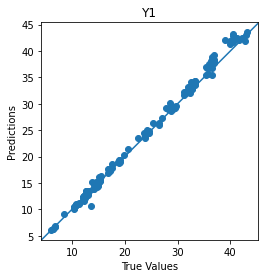

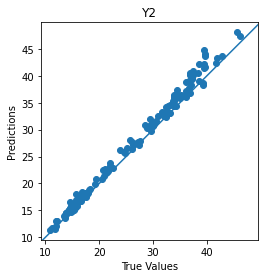

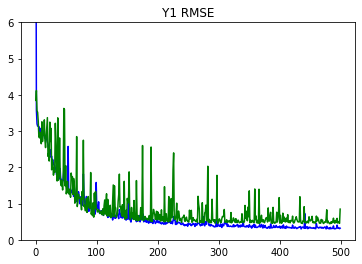

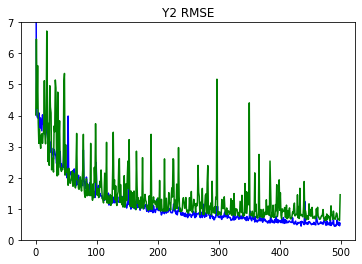

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)